May 4: A closer look at the bathymetry of Mackenzie Canyon as depicted by the IBCAO_V3_500m_RR grid.

* title: J:\jazz3\IBCAO_ASCII_INPUTDATA\ver3.0\\resamp_grd01.grd
* history: grdmath resamp_grd01.grd IBCAO_diff.grd ADD = IBCAO_final_RR.grd
* GMT_version: 4.5.8
* dimensions(sizes): x(11617), y(11617)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)
 

* float64 x(x), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float64 y(y), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float32 z(y, x), actual_range: [-5573.01660156  5921.39746094], current shape = (11617, 11617)

Modified version of the ibcao.py module in make_bathymetry.ipynb.

In [9]:
import  numpy as np
import  os
import  scipy as sc, scipy.io
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from    pyproj import Proj, Geod
import  cartopy.crs as ccrs
%matplotlib inline

In [10]:
ibcao_grid_name = 'IBCAO_V3_500m_RR.grd'
ibcao_grid_dir = '/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid'
ibcao_grid = os.path.join(ibcao_grid_dir, ibcao_grid_name)
ibcao_nc = scipy.io.netcdf_file (ibcao_grid)

x = ibcao_nc.variables['x'][:]
y = ibcao_nc.variables['y'][:]
z = ibcao_nc.variables['z'][:]

In [82]:
def Colormap():
    """
    return a discrete colormap and norm based on the official IBCAO colormap.

    usage:

    (cmap, norm) = self.Colormap ()
    cm = ax.pcolormesh (x, y, z, cmap = cmap, norm = norm)
    plt.colorbar (cm)

    """

    # loader based on: http://wiki.scipy.org/Cookbook/Matplotlib/Loading_a_colormap_dynamically and
    # http://stackoverflow.com/questions/26559764/matplotlib-pcolormesh-discrete-colors
    
    COLORMAP = """\
    # downloaded from IBCAO homepage
    #Discrete color table for Ocean and continous for land in RGB for the Arctic bathymetry and topography
    -6000	18	10	59	-5000	18	10	59
    -5000	22	44	103	-4000	22	44	103
    -4000	22	88	135	-3000	22	88	135
    -3000	22	138	170	-2000	22	138	170
    -2000	22	154	184	-1500	22	154	184
    -1500	23	170	198	-1000	23	170	198
    -1000	23	186	212	-500	23	186	212
    -500	24	196	223	-250	24	196	223
    -250	25	206	234	-100	25	206	234
    -100	27	216	245	-75	27	216	245
    -75	38	223	241	-50	38	223	241
    -50	49	230	236	-25	49	230	236
    -25	105	242	233	-10	105	242	233
    -10	161	255	230	0	161	255	230
    0	40	158	38	25	44	176	42
    25	44	176	42	50	49	195	46
    50	49	195	46	75	145	208	80
    75	145	208	80	100	242	202	90
    100	242	202	90	200	227	170	48
    200	227	170	48	300	190	140	40
    300	190	140	40	400	151	109	31
    400	151	109	31	500	114	80	23
    500	114	80	23	600	95	63	12
    600	95	63	12	700	81	57	16
    700	81	57	16	800	114	97	71
    800	114	97	71	1000	105	105	105
    1000	105	105	105	1500	170	170	170
    1500	170	170	170	5000	200	200	200
    """

    cmap = np.empty ((0,4))
    c = 0

    for l in COLORMAP.split("\n"):
      l = l.strip()

      if len(l) == 0 or l[0] == '#':
        continue

      ls = np.array([float (v) for v in l.split ()])

      if ls.shape[0] < 8:
        continue

      c += 1
      cmap.resize (c, 4)
      cmap[c-1,:] = ls[:4]

    # add end spec
    c += 1
    cmap.resize (c, 4)
    cmap[c-1,:] = ls[4:]

    # normalize colors
    cmap[:,[1, 2, 3]] = cmap[:,[1, 2, 3]] / 255.

    cmap_out = cm.colors.ListedColormap (cmap[:,1:4], 'ibcao', c)
    norm     = cm.colors.BoundaryNorm (cmap[:,0], c)

    return (cmap_out, norm)

def get_cartopy ():
    m = ccrs.Stereographic(central_latitude=90, central_longitude=0, false_easting=0, false_northing=0, 
                           true_scale_latitude=75.0)
    return m

In [12]:
def return_boundaries(xl, xr, yb, yt, case):
    '''Extracts region from full bathymetry file.
    xl=-; xr=-; yb=; yt=
    '''
    if case == 'region':
        xl=-1800000; xr=-700000; yb=1200000; yt=2000000
    elif case == 'canyon':
        xl=-1630000; xr=-1320000; yb=1560000; yt=1730000
    elif case == 'HS':
        xl=-1630000; xr=-1460000; yb=1600000; yt=1710000
    elif case == 'yn':
        xl=-1630000; xr=-1450000; yb=1640000; yt=1730000
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(x==xl)[0][0]
    xmax = np.where(x==xr)[0][0]
    ymin = np.where(x==yb)[0][0]
    ymax = np.where(x==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

In [13]:
def plot_mackenzie(ax, xn, yn, zn, plot_type):
    '''Plots canyon bathymetry using xn, yn, and zn
    for region specified in the return_boundaries function.
    '''
    (cmap, norm) = Colormap()
    if plot_type == 'full':
        c = ax.pcolorfast(xn,yn,zn,cmap=cmap)
        fig.colorbar(c)
    if plot_type == 'contour':
        cs = ax.contour(xn,yn,zn,100,linewidths=2,cmap=cmap)
        ax.clabel(cs, inline=1, fontsize=10)
        cb = fig.colorbar(cs)
        for line in cb.lines: 
           line.set_linewidth(12)
    if plot_type=='surface':
        Xn, Yn = np.meshgrid(xn, yn)
        surf = ax.plot_surface(Xn, Yn, zn, cmap=cmap, linewidth=0, rstride=1, cstride=1, antialiased=False)
        fig.colorbar(surf, shrink=0.5)
    return ax

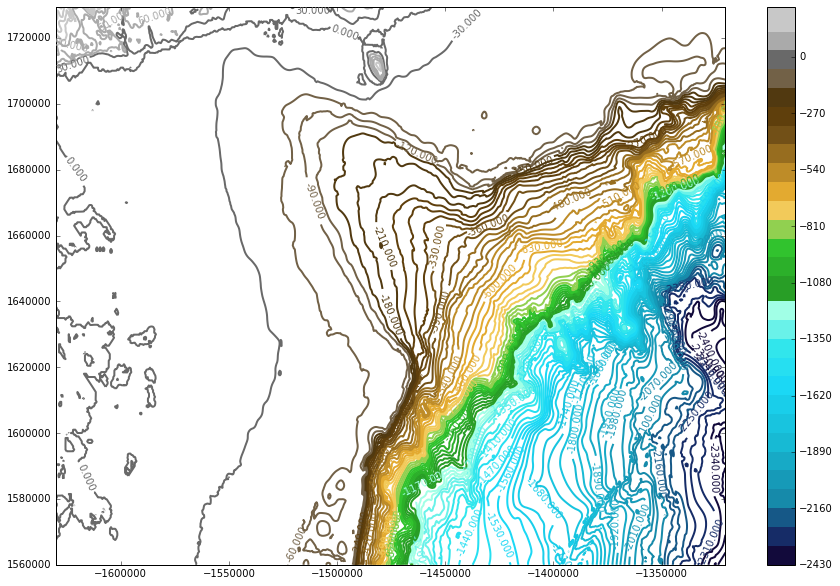

In [65]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
xn, yn, zn = return_boundaries(0, 0, 0, 0, 'canyon')
ax = plot_mackenzie(ax, xn, yn, zn, 'contour')

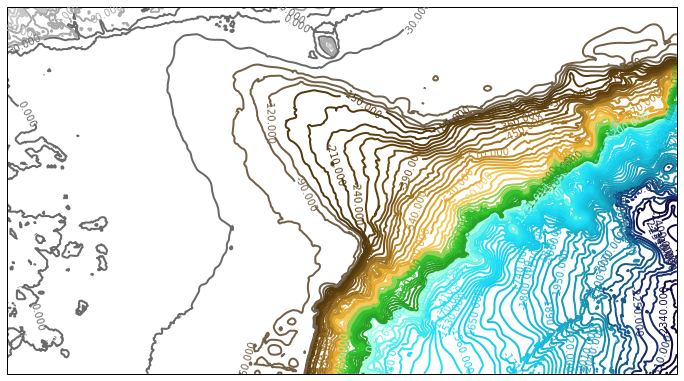

In [84]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=get_cartopy())
xn, yn, zn = return_boundaries(0, 0, 0, 0, 'canyon')
ax = plot_mackenzie(ax, xn, yn, zn, 'contour')

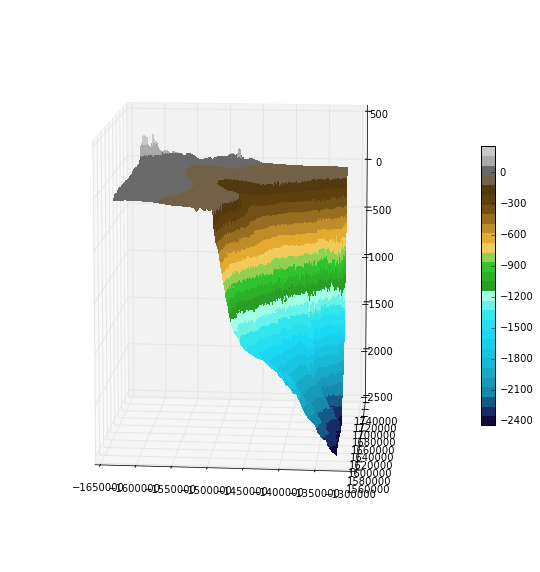

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
xn, yn, zn = return_boundaries(0, 0, 0, 0, 'canyon')
ax = plot_mackenzie(ax, xn, yn, zn, 'surface')
ax.view_init(elev=10, azim=-85)

$H_D$ = maximum depth in domain: case='canyon' shows the domain of interest for the canyon. np.amin(zn) gives the maximum depth (-2445.8433 m). However, this is the maximum depth in the domain, not in the canyon. Consider, finding the depth at the mouth of the canyon.

$H_S$ = shelf depth: case='HS' shows region near shelf break along eastern wall of canyon. 'contour' and 'surface' shows that at this depth, the bathymetry (80 m) falls quickly.

* $y_c$ = steepness of the continental slope

$y_n$ = distance between head and coast: case='yn' zooms into the canyon head near the coastline. The line plotted with ax.plot([-1516000, -1556000],[1698000, 1722000], 'r', linewidth=5) connects the head and coastline. x and y are in Polar stereographic coordinates.

* $y_b$ = distance between head and shelf break
* $x_0$ = location of axis
* $b$ = canyon width

In [68]:
HD = -2445.8433 
HS = -80.0

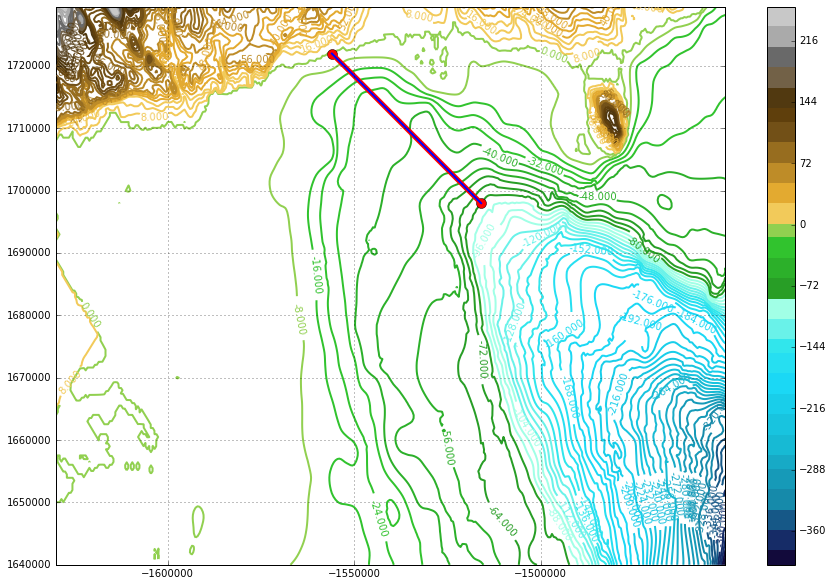

In [64]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
xn, yn, zn = return_boundaries(0, 0, 0, 0, 'yn')
ax = plot_mackenzie(ax, xn, yn, zn, 'contour')
ax.plot(-1516000, 1698000, 'ro', markersize=10)
ax.plot(-1556000, 1722000, 'ro', markersize=10)
ax.plot([-1516000, -1556000],[1698000, 1722000], 'r', linewidth=5)
ax.grid()

ax.plot([xn[np.where(xn==-1516000)[0][0]], xn[np.where(xn==-1556000)[0][0]]],
        [yn[np.where(yn==1698000)[0][0]], yn[np.where(yn==1722000)[0][0]]], 'b', linewidth=2)


https://en.wikipedia.org/wiki/Stereographic_projection

https://www.uwgb.edu/dutchs/structge/sphproj.htm